# Introduction

Two-sample Mendelian Randomization (MR) is a powerful statistical method used to infer causal relationships between risk factors and health outcomes using genetic data. In this approach, genetic variants associated with an exposure (such as cholesterol levels) are used as instruments to assess their effect on an outcome (like heart disease) in separate, independent samples. By leveraging genetic variants, which are randomly allocated and less influenced by confounding factors, two-sample MR provides a robust way to estimate causal effects and avoid some of the biases present in traditional observational studies.

This method involves obtaining summary statistics from two distinct datasets: one for the exposure and one for the outcome. By combining these datasets, researchers can estimate the causal effect of the exposure on the outcome with increased statistical power and precision. Two-sample MR is widely used in public health and biostatistics to provide insights into how modifiable risk factors impact health outcomes, guiding more effective prevention and treatment strategies.

In this notebook you will perform a two-sample Mendelian Randomization study. We will apply MR-IVW (Inverse-Variance Weighted) and MR-Egger on a toy dataset to estimate causal effects. MR-IVW combines multiple genetic instruments by weighting them according to their precision, assuming all instruments are valid. In contrast, MR-Egger Regression allows for potential pleiotropy (where instruments affect the outcome through pathways other than the exposure) by including an intercept term to adjust for directional pleiotropy, providing a more flexible approach when there are concerns about instrument validity. At the end there is a bonus question to run five main MR methods all together on the simulated data and analyze the results.

# Load and preprocess the data

First please load the data in `../data/MR_genotype_data_with_missing.csv` and `../data/MR_phenotype_data_with_missing.csv` and name them `genotype_data` and `phenotype_data`. Keep the names same before and after the imputation.

***

In [1]:
library(readr)

# Load the data
genotype_data <- read_csv('./data/MR_genotype_data_with_missing.csv')
phenotype_data <- read_csv('../data/MR_phenotype_data_with_missing.csv')

head(genotype_data)
head(phenotype_data)

Rows: 1000 Columns: 51
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (51): Individual_ID, rs1, rs2, rs3, rs4, rs5, rs6, rs7, rs8, rs9, rs10, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1000 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Sex
dbl (4): Individual_ID, Exposure, Outcome, Age

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Individual_ID,rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,⋯,rs41,rs42,rs43,rs44,rs45,rs46,rs47,rs48,rs49,rs50
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,0,0,0,0,2,1,⋯,0,2,0,0,0,1,1,0,0,1
2,1,1,0,2,1,2,0,1,0,⋯,2,0,1,0,1,0,0,0,0,1
3,0,0,0,0,1,1,0,0,1,⋯,0,NA,0,2,NA,1,0,NA,2,0
4,1,1,1,1,1,1,1,1,0,⋯,0,2,0,1,2,0,0,0,0,0
5,2,1,1,0,0,0,0,0,1,⋯,0,0,1,0,0,1,0,0,1,0
6,0,0,1,1,0,0,1,1,1,⋯,0,0,1,0,0,0,0,1,0,0


Individual_ID,Exposure,Outcome,Age,Sex
<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,1.099167,3.651814,55.82143,Male
2,3.659277,4.472440,52.73928,Male
3,2.318354,3.518236,48.91946,Female
4,4.890220,6.910572,52.02900,Female
5,1.932015,3.639968,56.09176,Male
6,2.547696,3.485149,57.15830,Male


**Question 1: analyze the pattern of missing data in the phenotype dataset. Are there any specific patterns (e.g., missingness concentrated in certain columns or rows)?**


 Variables sorted by number of missings: 
      Variable Count
      Exposure  0.03
       Outcome  0.02
 Individual_ID  0.00
           Age  0.00
           Sex  0.00


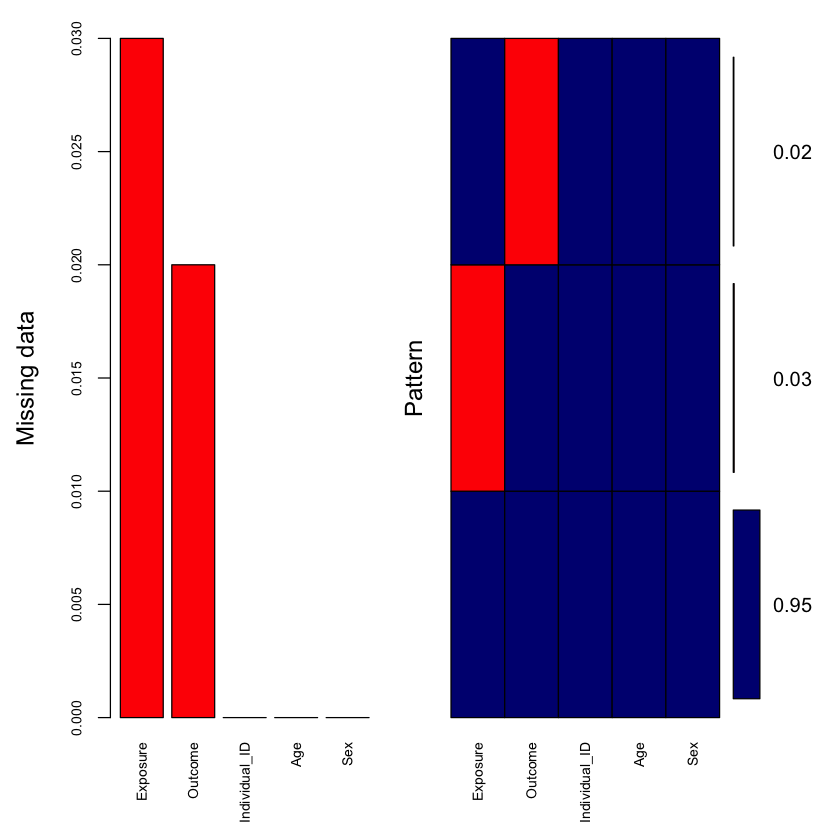

,Individual_ID,Age,Sex,Outcome,Exposure,
950,1,1,1,1,1,0
30,1,1,1,1,0,1
20,1,1,1,0,1,1
,0,0,0,20,30,50


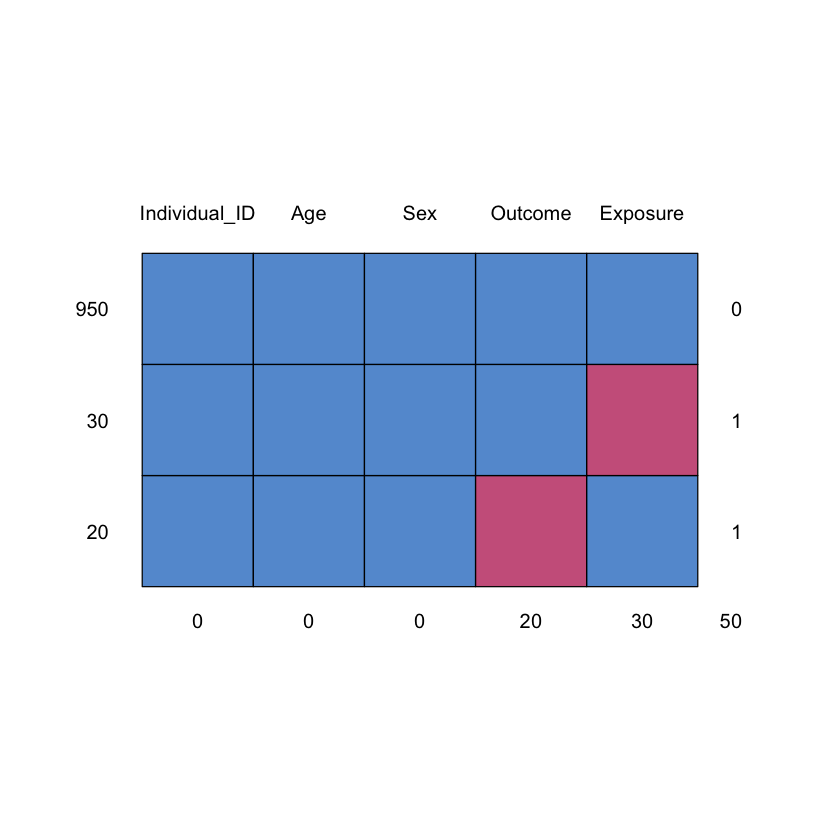

In [5]:
library(VIM)
aggr_plot <- aggr(phenotype_data, col=c('navyblue','red'), numbers=TRUE, sortVars=TRUE, labels=names(phenotype_data), cex.axis=.7, gap=3, ylab=c("Missing data","Pattern"))

library(mice)
md.pattern(phenotype_data)

**Answer:**
There are 50 missing values in total, column exposure has 30 missing value, and outcome column have 20 missing values.

***

**Question 2: given the missingness of data, please perform mode imputation for the genotype data and mean imputation for the phenotype data. Report what is the average age after imputation?**

In [9]:
library(mice)

#mode imputation
mode_impute <- function(x) {
    ux <- unique(x)
    ux[which.max(tabulate(match(x, ux)))]
}

genotype_data_imputed <- genotype_data
for (col in colnames(genotype_data_imputed)) {
    if (any(is.na(genotype_data_imputed[[col]]))) {
        genotype_data_imputed[[col]][is.na(genotype_data_imputed[[col]])] <- mode_impute(genotype_data_imputed[[col]])
    }
}

head(genotype_data_imputed)

Individual_ID,rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,⋯,rs41,rs42,rs43,rs44,rs45,rs46,rs47,rs48,rs49,rs50
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,0,0,0,0,2,1,⋯,0,2,0,0,0,1,1,0,0,1
2,1,1,0,2,1,2,0,1,0,⋯,2,0,1,0,1,0,0,0,0,1
3,0,0,0,0,1,1,0,0,1,⋯,0,0,0,2,0,1,0,0,2,0
4,1,1,1,1,1,1,1,1,0,⋯,0,2,0,1,2,0,0,0,0,0
5,2,1,1,0,0,0,0,0,1,⋯,0,0,1,0,0,1,0,0,1,0
6,0,0,1,1,0,0,1,1,1,⋯,0,0,1,0,0,0,0,1,0,0


In [10]:
#mean imputation
phenotype_data_imputed <- phenotype_data
for (col in colnames(phenotype_data_imputed)) {
    if (any(is.na(phenotype_data_imputed[[col]]))) {
        phenotype_data_imputed[[col]][is.na(phenotype_data_imputed[[col]])] <- mean(phenotype_data_imputed[[col]], na.rm = TRUE)
    }
}

# Calculate the average age after imputation
average_age <- mean(phenotype_data_imputed$Age, na.rm = TRUE)
average_age

[1] 49.65433

**Answer:**
the average age for phenotype data after mean imputation is 49.65.

***

# Instrument selection

Now we can use the genotype data to calculate SNP-exposure associations (i.e., estimate the beta values for SNPs). Basically you can do a linear regression between the exposure and each variant and collect the coefficients:

In [11]:
snp_exposure_results <- data.frame(SNP = colnames(genotype_data)[-1],
                                    Beta = numeric(ncol(genotype_data) - 1),
                                    SE = numeric(ncol(genotype_data) - 1))

for (snp in colnames(genotype_data)[-1]) {
  genotype <- genotype_data[[snp]]
  exposure <- phenotype_data$Exposure
  fit <- lm(exposure ~ genotype)
  snp_exposure_results$Beta[snp_exposure_results$SNP == snp] <- coef(fit)[2]
  snp_exposure_results$SE[snp_exposure_results$SNP == snp] <- summary(fit)$coefficients[2, 2]
}

***

**Question 3: please only select the variants with p-value smaller than 0.01. How many are there?**

In [14]:
# Calculate p-values for SNP-exposure associations
snp_exposure_results$p_value <- numeric(nrow(snp_exposure_results))

for (snp in colnames(genotype_data)[-1]) {
    genotype <- genotype_data[[snp]]
    exposure <- phenotype_data$Exposure
    fit <- lm(exposure ~ genotype)
    snp_exposure_results$p_value[snp_exposure_results$SNP == snp] <- summary(fit)$coefficients[2, 4]
}

# Select variants with p-value less than 0.01
significant_snps <- snp_exposure_results[snp_exposure_results$p_value < 0.01, ]
n_significant_snps <- nrow(significant_snps)
n_significant_snps

[1] 14

**Answer:**
There are 14 variants with p-values smaller than 0.01.

***

# SNP-outcome association

***

**Question 4: please run the association analysis between variants and the outcome.**

**Answer:**

In [15]:
snp_outcome_results <- data.frame(SNP = colnames(genotype_data)[-1],
                                  Beta = numeric(ncol(genotype_data) - 1),
                                  SE = numeric(ncol(genotype_data) - 1))

for (snp in colnames(genotype_data)[-1]) {
  genotype <- genotype_data[[snp]]
  outcome <- phenotype_data$Outcome
  fit <- lm(outcome ~ genotype)
  snp_outcome_results$Beta[snp_outcome_results$SNP == snp] <- coef(fit)[2]
  snp_outcome_results$SE[snp_outcome_results$SNP == snp] <- summary(fit)$coefficients[2, 2]
}

head(snp_outcome_results)

,SNP,Beta,SE
,<chr>,<dbl>,<dbl>
1,rs1,-0.05018171,0.05776134
2,rs2,0.45749652,0.05614654
3,rs3,0.20220314,0.05643776
4,rs4,0.16983871,0.05624217
5,rs5,0.07301148,0.05901615
6,rs6,0.11571641,0.05744714


***

# Run two-sample MR

Noe we are ready to run the two-sample MR analysis. Here we can use a R package called [`MendelianRandomization` on CRAN](https://cran.r-project.org/web/packages/MendelianRandomization/index.html).

In [16]:
# Install MendelianRandomization package if not already installed
if (!requireNamespace("MendelianRandomization", quietly = TRUE)) {
  install.packages("MendelianRandomization")
}

# Load the package
library(MendelianRandomization)

also installing the dependencies ‘crosstalk’, ‘gmp’, ‘arrangements’, ‘plotly’, ‘iterpc’, ‘rjson’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In the vignette [here](https://cran.r-project.org/web/packages/MendelianRandomization/vignettes/Vignette_MR.pdf), please learn how to apply two basic MR methods -- MR-IVW amd MR-Egger. 

**Hint: the input for `mr_ivw` function consists of four components: coefficients and standard errors between variants and exposures, and between variants and outcome. Same for `mr_egger`. Check page 4 and 6 on the vignette PDF.**

***

**Question 5: please run the MR-IVW and MR-Egger analysis.**

**Answer:**

In [18]:
# Prepare the input data for MR analysis
merged_results <- merge(snp_exposure_results, snp_outcome_results, by = "SNP", suffixes = c("_exposure", "_outcome"))

# Run MR-IVW analysis
mr_input_data <- mr_input(bx = merged_results$Beta_exposure, bxse = merged_results$SE_exposure, 
                          by = merged_results$Beta_outcome, byse = merged_results$SE_outcome)
mr_ivw_results <- mr_ivw(mr_input_data)

# Display the results
mr_ivw_results


Inverse-variance weighted method
(variants uncorrelated, random-effect model)

Number of Variants : 50 

------------------------------------------------------------------
 Method Estimate Std Error 95% CI       p-value
    IVW    1.120     0.152 0.822, 1.417   0.000
------------------------------------------------------------------
Residual standard error =  2.343 
Heterogeneity test statistic (Cochran's Q) = 268.9641 on 49 degrees of freedom, (p-value = 0.0000). I^2 = 81.8%. 
F statistic = 5.0. 

In [19]:
#MR-Egger analysis
mr_egger_results <- mr_egger(mr_input_data)
mr_egger_results


MR-Egger method
(variants uncorrelated, random-effect model)

Number of Variants =  50 

------------------------------------------------------------------
      Method Estimate Std Error  95% CI       p-value
    MR-Egger    0.819     0.326  0.180, 1.459   0.012
 (intercept)    0.043     0.041 -0.038, 0.123   0.299
------------------------------------------------------------------
Residual Standard Error :  2.341 
Heterogeneity test statistic = 263.0418 on 48 degrees of freedom, (p-value = 0.0000)
I^2_GX statistic: 8.0%

***

# Analyze the results

***

**Question 6: Using the MR-IVW and MR-Egger methods, report the estimated causal effect of the exposure on the outcome, along with standard errors, 95% confidence intervals, and p-values. Compare the estimates from MR-IVW and MR-Egger. What are the key differences between the two methods in your results?**

**Answer:**

In [20]:
# MR-IVW results
ivw_estimate <- mr_ivw_results$Estimate
ivw_se <- mr_ivw_results$StdError
ivw_ci_lower <- mr_ivw_results$CILower
ivw_ci_upper <- mr_ivw_results$CIUpper
ivw_p_value <- mr_ivw_results$Pvalue

cat("MR-IVW Results:\n")
cat("Estimate:", ivw_estimate, "\n")
cat("Standard Error:", ivw_se, "\n")
cat("95% CI:", ivw_ci_lower, "-", ivw_ci_upper, "\n")
cat("P-value:", ivw_p_value, "\n\n")

# MR-Egger results
egger_estimate <- mr_egger_results$Estimate
egger_se <- mr_egger_results$StdError.Est
egger_ci_lower <- mr_egger_results$CILower.Est
egger_ci_upper <- mr_egger_results$CIUpper.Est
egger_p_value <- mr_egger_results$Pvalue.Est

cat("MR-Egger Results:\n")
cat("Estimate:", egger_estimate, "\n")
cat("Standard Error:", egger_se, "\n")
cat("95% CI:", egger_ci_lower, "-", egger_ci_upper, "\n")
cat("P-value:", egger_p_value, "\n")

MR-IVW Results:
Estimate: 1.119667 
Standard Error: 0.1516632 
95% CI: 0.8224124 - 1.416921 
P-value: 1.55244e-13 

MR-Egger Results:
Estimate: 0.8192783 
Standard Error: 0.3262803 
95% CI: 0.1797807 - 1.458776 
P-value: 0.01204017 


```markdown
**Interpretation of the Estimated Causal Effect:**

- **Estimate:** The estimated causal effect of the exposure on the outcome.
- **Standard Error:** The standard error of the estimate.
- **95% Confidence Interval (CI):** The range within which the true causal effect is expected to lie with 95% confidence.
- **P-value:** The probability that the observed effect is due to chance.

**Comparison of MR-IVW and MR-Egger:**
- **Estimates:** The estimated causal effect is smaller for MR-Egger (0.82) compared to the MR-IVW result, which could indicate the presence of pleiotropy or bias that MR-Egger is adjusting for.
- **Standard Errors:** The larger standard error in the MR-Egger result reflects the additional flexibility of the method, as it allows for directional pleiotropy. 
- **Confidence Intervals:** The confidence interval for MR-Egger is wider compared to MR-IVW and crosses 1, suggesting that the effect may not be significant in this case.
- **P-values:** both p-values are statistically significant (<0.05), but not as strongly significant as the MR-IVW result..


In summary, MR-IVW provides a more precise estimate under the assumption of no pleiotropy, while MR-Egger offers a more flexible approach that accounts for potential pleiotropy but with increased uncertainty.
```

***

**Question 7 (optional): Run all the primary Mendelian Randomization methods using the `mr_allmethods` function from the package (use the code below). Visualize the results with the `mr_plot` function. Based on your findings, provide an analysis of the results and discuss the reasons for any observed patterns or outcomes.**

```R
res = mr_allmethods(mr_input(bx=merged_results$Beta_exposure, bxse=merged_results$SE_exposure, 
                               by=merged_results$Beta_outcome, byse=merged_results$SE_outcome), method = "main")
```


In [22]:
res = mr_allmethods(mr_input(bx=merged_results$Beta_exposure, bxse=merged_results$SE_exposure, 
                               by=merged_results$Beta_outcome, byse=merged_results$SE_outcome), method = "main")

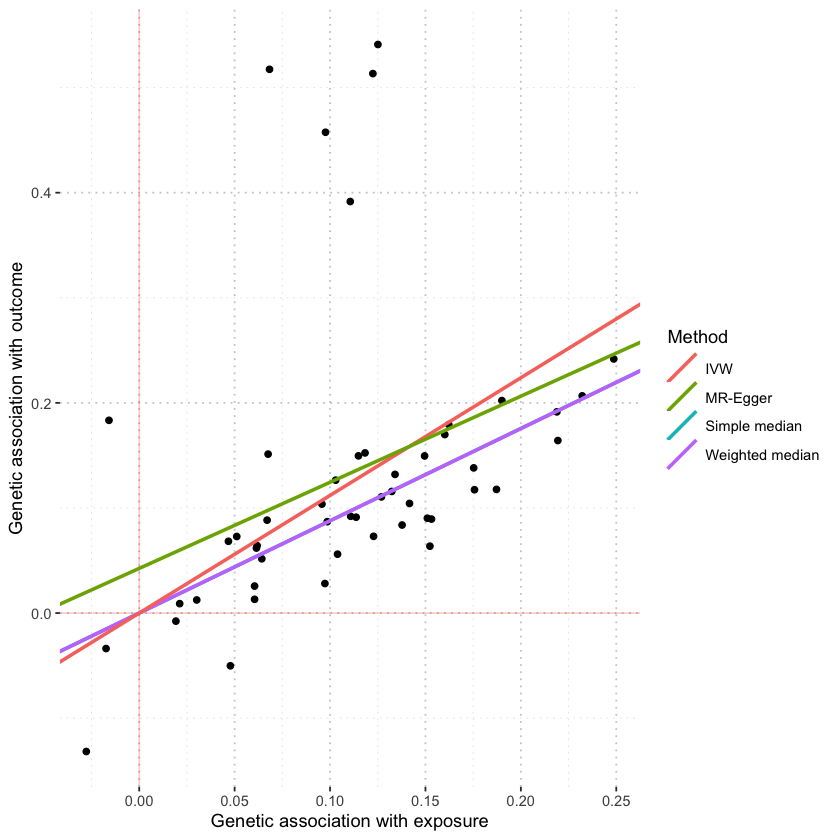

In [24]:
mr_plot(res)

The Inverse-Variance Weighted (IVW) method provides the steepest slope, indicating a stronger estimated causal effect of the exposure on the outcome compared to the other methods. The estimates from MR-Egger, Simple Median, and Weighted Median are fairly close, which indicates robustness in the causal inference. However, the MR-IVW method provides a stronger estimate, suggesting that the assumptions made by IVW (no pleiotropy) might be too optimistic. The non-zero intercept in MR-Egger and the lower slope compared to IVW indicates that pleiotropy is likely present. 
